In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

import xml.etree.ElementTree as ET

In [2]:
mtu = 1500.
num_flows = 500.

# baseRTTs = [i for i in range(10,10000,1000)]
baseRTTs = [100.,130.,160.,200.]
# bandwidths = [i for i in range(10,100,10)]
bandwidths = [1., 3., 5., 7., 10.]

In [3]:
# losses = []
# thps = []
# rtts = []
# cwnds = []

columns = ['base_thp', 'ave_thp', 'base_rtt', 'loss',
           'ave_rtt', 'med_rtt', 'std_rtt', 
           'ave_cwnd', 'med_cwnd', 'std_cwnd']
data = []

for baseRTT in baseRTTs:
    for bandwidth in bandwidths:
        content = []
        prefix_file_name = 'SimpleTcpStats-'+str(int(bandwidth))+'Gbps-'+str(int(baseRTT))+'us'

        content.append(bandwidth/num_flows*1e9/8/mtu) # packet-per-second
        
        flowmon_filename = prefix_file_name+'.flowmonitor'
        if (not os.path.exists(flowmon_filename)):
            print('{} no found!'.format(flowmon_filename))
#             continue
            content.append(np.nan)
            content.append(baseRTT/1e6,) # seconds
            content.append(np.nan)
        else:
            tree = ET.parse(flowmon_filename)
            root = tree.getroot()

            # Find the flow ID of the flow of interest
            for Ipv4FlowClassifier in root.iter('Ipv4FlowClassifier'):
                for Flow in Ipv4FlowClassifier.iter('Flow'):
                    if Flow.attrib['sourceAddress'] == '10.0.2.1':
                        flow_id = Flow.attrib['flowId']
                        break

            # Extract the stats regarding the flow of interest
            for FlowStats in root.iter('FlowStats'):
                if FlowStats.attrib != {}:
                    continue
                for Flow in FlowStats.iter('Flow'):
                    if Flow.attrib['flowId'] == flow_id:
                        timeFirstTxPacket = float(Flow.attrib['timeFirstTxPacket'].split('+')[1].split('ns')[0])
                        timeLastTxPacket = float(Flow.attrib['timeLastTxPacket'].split('+')[1].split('ns')[0])
                        txBytes = float(Flow.attrib['txBytes'])
                        txPackets = float(Flow.attrib['txPackets'])
                        lostPackets = float(Flow.attrib['lostPackets'])

                        thp = txPackets/(timeLastTxPacket-timeFirstTxPacket)*1e9 # packet-per-second
                        content.append(thp)
                        content.append(baseRTT/1e6,) # seconds

                        loss_rate = lostPackets/txPackets
                        content.append(loss_rate)

    #                     print('Throughput: {} pps, Loss Rate: {}'.format(thp,loss_rate))
    #                     losses.append(loss_rate)
    #                     thps.append(thp)
                        break
                break

        # Calculate the RTT of the flow
        rtt_filename = prefix_file_name+'-rtt.data'

        time_series_rtts = []
        with open(rtt_filename,'r') as f:
            for line in f:
                t, rtt = line.split()
                time_series_rtts.append(float(rtt)) # seconds
        time_series_rtts = np.asarray(time_series_rtts)
#         rtts.append(np.median(time_series_rtts))
        content.append(np.mean(time_series_rtts))
        content.append(np.median(time_series_rtts))
        content.append(np.std(time_series_rtts))

        # Calculate the median cwnd of the flow
        cwnd_filename = prefix_file_name+'-cwnd.data'

        time_series_cwnds = []
        with open(cwnd_filename,'r') as f:
            for line in f:
                t, cwnd = line.split()
                time_series_cwnds.append(float(cwnd))
        time_series_cwnds = np.asarray(time_series_cwnds)
#         cwnds.append(np.median(time_series_cwnds))
        content.append(np.mean(time_series_cwnds))
        content.append(np.median(time_series_cwnds))
        content.append(np.std(time_series_cwnds))
        
        data.append(content)
        
# losses = np.asarray(losses)
# thps = np.asarray(thps)
# rtts = np.asarray(rtts)
# cwnds = np.asarray(cwnds)
stats_df = pd.DataFrame(data,columns=columns)
print(stats_df)

SimpleTcpStats-7Gbps-100us.flowmonitor no found!
SimpleTcpStats-3Gbps-200us.flowmonitor no found!
       base_thp       ave_thp  base_rtt      loss   ave_rtt   med_rtt  \
0    166.666667    504.551466   0.00010  0.076379  0.012902  0.006753   
1    500.000000    939.111078   0.00010  0.044388  0.007545  0.001545   
2    833.333333    931.028585   0.00010  0.037655  0.007018  0.001910   
3   1166.666667           NaN   0.00010       NaN  0.003211  0.001011   
4   1666.666667   2610.876738   0.00010  0.021934  0.003167  0.001021   
5    166.666667    298.108939   0.00013  0.063294  0.010832  0.004767   
6    500.000000    613.112066   0.00013  0.036990  0.005948  0.001233   
7    833.333333    632.942560   0.00013  0.037579  0.006083  0.001265   
8   1166.666667   1129.633290   0.00013  0.030959  0.005552  0.001156   
9   1666.666667   3858.493375   0.00013  0.010426  0.002687  0.001009   
10   166.666667    279.158790   0.00016  0.054559  0.009651  0.002522   
11   500.000000    808.446

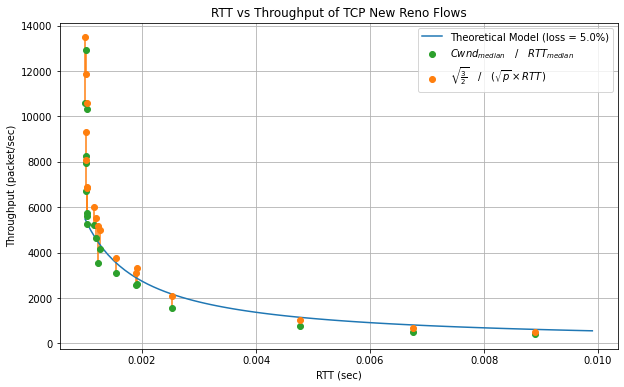

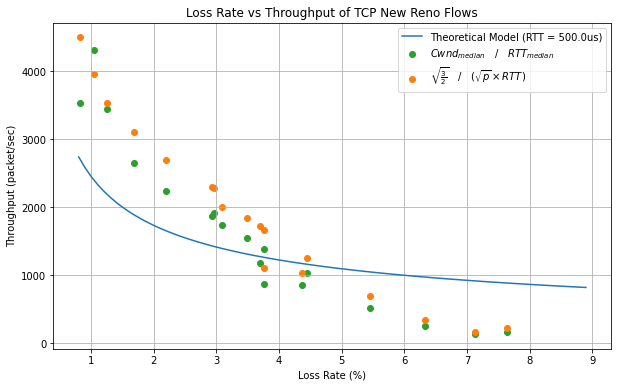

In [4]:
# analytical_thps = math.sqrt(1.5)/np.multiply(np.sqrt(losses),rtts)
# cwnd_estimate_thps = np.divide(cwnds,rtts)/mtu
stats_df['analytical_thp'] = math.sqrt(1.5) / (np.sqrt((stats_df.loss))*stats_df.med_rtt)
stats_df['cwnd_est_thp'] = stats_df.med_cwnd / stats_df.med_rtt / mtu

model_loss = 0.05
model_rtts = np.arange(0.001,0.01,0.0001)
model_thps = math.sqrt(1.5)/math.sqrt(model_loss)/model_rtts

plt.figure()
# plt.scatter(stats_df.med_rtt, stats_df.ave_thp, 
#             label='Simulation Measurements')

# Add lines between theoretical and actual measurements
for _, row in stats_df.iterrows():
    x = row['med_rtt']
    y1 = row['cwnd_est_thp']
    y2 = row['analytical_thp']
    if not np.isnan(y2):
        plt.plot([x,x],[y1,y2], c='C1')

plt.scatter(stats_df.med_rtt, stats_df.cwnd_est_thp, zorder=30,
            label=r"$Cwnd_{median}\quad/\quadRTT_{median}$", c='C2')
plt.scatter(stats_df.med_rtt, stats_df.analytical_thp, zorder=30,
            label=r"$\sqrt{\frac{3}{2}}\quad/\quad(\sqrt{p} \times RTT)$", c='C1')
plt.plot(model_rtts, model_thps, 
         label='Theoretical Model (loss = {}%)'.format(model_loss*100), c='C0')

plt.legend()
plt.ylabel('Throughput (packet/sec)')
plt.xlabel('RTT (sec)')
plt.title('RTT vs Throughput of TCP New Reno Flows')
plt.grid()
plt.show()

model_rtt = 0.0005
model_losses = np.arange(0.8,9,0.1)
model_thps = math.sqrt(1.5)/(model_losses**(1/2))/model_rtt

plt.figure()
# plt.scatter(stats_df.loss*100, stats_df.ave_thp, 
#             label='Simulation Measurements')
plt.scatter(stats_df.loss*100, stats_df.cwnd_est_thp/3, 
            label=r"$Cwnd_{median}\quad/\quadRTT_{median}$", c='C2')
plt.scatter(stats_df.loss*100, stats_df.analytical_thp/3, 
            label=r"$\sqrt{\frac{3}{2}}\quad/\quad(\sqrt{p} \times RTT)$", c='C1')
plt.plot(model_losses,model_thps, label='Theoretical Model (RTT = {}us)'.format(model_rtt*1e6))

# plt.ylim((0,5000))
plt.legend()
plt.ylabel('Throughput (packet/sec)')
plt.xlabel('Loss Rate (%)')
plt.title('Loss Rate vs Throughput of TCP New Reno Flows')
plt.grid()
plt.show()

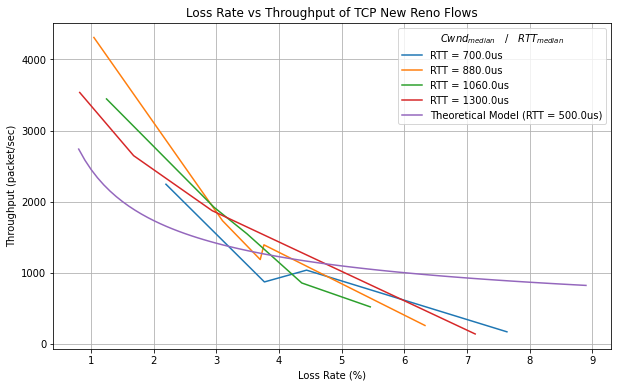

In [5]:
plt.figure()
model_rtt = 0.0005
model_losses = np.arange(0.8,9,0.1)
model_thps = math.sqrt(1.5)/(model_losses**(1/2))/model_rtt
    
for base_rtt,df in stats_df.groupby('base_rtt'):
    df = df.sort_values(by=['loss'])
    
    # plt.scatter(stats_df.loss*100, stats_df.ave_thp, 
    #             label='Simulation Measurements')
    plt.plot(df.loss*100, df.cwnd_est_thp/3, 
                label='RTT = {:.1f}us'.format((base_rtt*6+1e-4)*1e6))
#     plt.scatter(df.loss*100, df.analytical_thp/3, 
#                 label=r"$\sqrt{\frac{3}{2}}\quad/\quad(\sqrt{p} \times RTT)$", c='C1')

    
plt.plot(model_losses,model_thps, label='Theoretical Model (RTT = {}us)'.format(model_rtt*1e6))

# plt.ylim((0,5000))
plt.legend(title=r"$Cwnd_{median}\quad/\quadRTT_{median}$")
plt.ylabel('Throughput (packet/sec)')
plt.xlabel('Loss Rate (%)')
plt.title('Loss Rate vs Throughput of TCP New Reno Flows')
plt.grid()
plt.show()

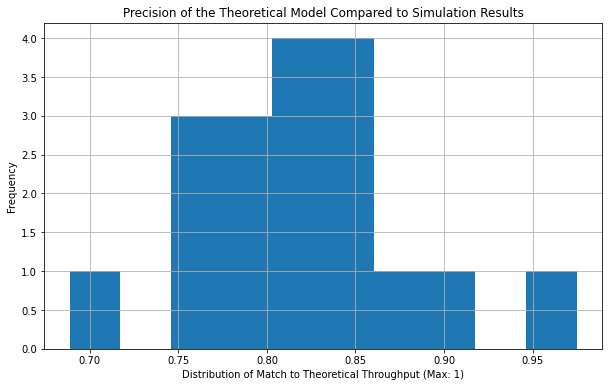

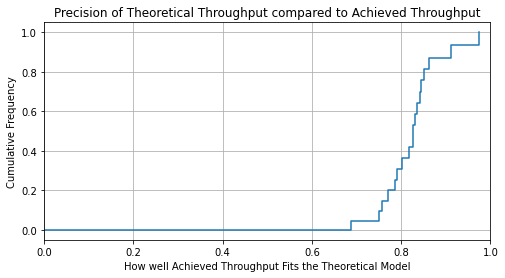

In [6]:
stats_df['thp_model_acc'] = np.abs(stats_df.analytical_thp - stats_df.cwnd_est_thp)
stats_df['thp_model_acc'] = stats_df.analytical_thp - stats_df['thp_model_acc']
stats_df['thp_model_acc'] /= stats_df.analytical_thp
stats_df = stats_df.sort_values(by=['thp_model_acc'])
stats_df['thp_model_acc_cdf'] = stats_df.thp_model_acc.cumsum()
stats_df['thp_model_acc_cdf'] /= stats_df['thp_model_acc_cdf'].max()

stats_df.thp_model_acc.hist()
plt.xlabel(r"Distribution of Match to Theoretical Throughput (Max: 1)")
plt.ylabel("Frequency")
plt.title("Precision of the Theoretical Model Compared to Simulation Results")
plt.show()

orig = pd.Series([0])
orig_acc = orig.append(stats_df['thp_model_acc'], ignore_index=True)
orig_acc_cdf = orig.append(stats_df['thp_model_acc_cdf'], ignore_index=True)
# end = pd.Series([1])
# orig_acc = orig_acc.append(end, ignore_index=True)
# orig_acc_cdf = orig_acc_cdf.append(end, ignore_index=True)

plt.figure(figsize=(8,4))
plt.step(orig_acc, orig_acc_cdf, where='post')
plt.xlim((0,1))
plt.title("Precision of Theoretical Throughput compared to Achieved Throughput")
plt.ylabel("Cumulative Frequency")
plt.xlabel("How well Achieved Throughput Fits the Theoretical Model")
plt.grid()
plt.show()

In [7]:
cwnd_times = []
cwnds = []
with open('SimpleTcpStats-100Mbps-10us-cwnd.data','r') as f:
    for line in f:
        time, cwnd = line.split()
        cwnd_times.append(float(time))
        cwnds.append(float(cwnd))
cwnds = np.asarray(cwnds)

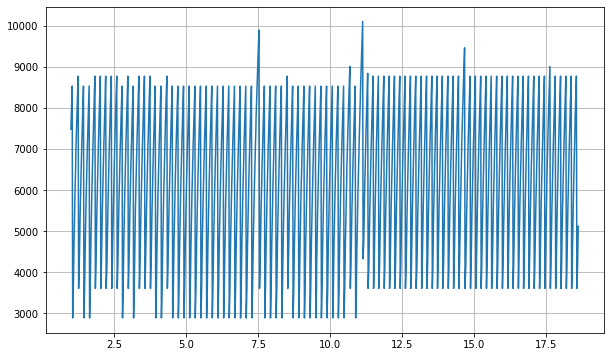

In [8]:
plt.plot(cwnd_times,cwnds)
# plt.ylim((0,1.5e5))
plt.grid()
plt.show()

In [9]:
rtt_times = []
rtts = []
with open('SimpleTcpStats-100Mbps-10us-rtt.data','r') as f:
    for line in f:
        time, rtt = line.split()
        rtt_times.append(float(time))
        rtts.append(float(rtt)*1000.)
rtts = np.asarray(rtts)

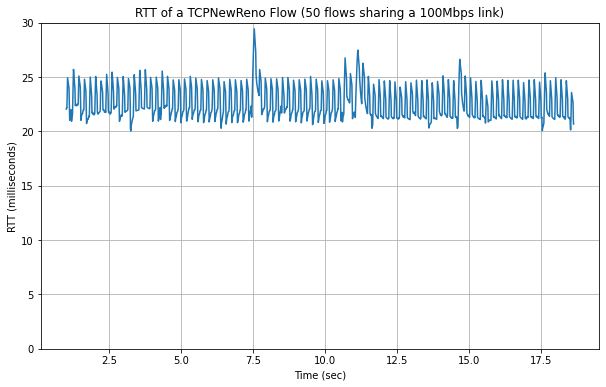

In [10]:
plt.figure()
plt.plot(rtt_times,rtts)
plt.title('RTT of a TCPNewReno Flow (50 flows sharing a 100Mbps link)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (milliseconds)')
# plt.xlim((1.1,1.2))
plt.ylim((0.0,30))
plt.grid()
plt.show()

In [12]:
# for baseRTT in baseRTTs:
#     for bandwidth in bandwidths:
#         prefix_file_name = 'SimpleTcpStats-'+str(int(bandwidth))+'Gbps-'+str(int(baseRTT))+'us'

#         # Calculate the RTT of the flow
#         rtt_filename = prefix_file_name+'-rtt.data'

#         time_series_rtts = []
#         times = []
#         with open(rtt_filename,'r') as f:
#             for line in f:
#                 t, rtt = line.split()
#                 time_series_rtts.append(float(rtt)*1000) # milliseconds
#                 times.append(float(t))
#         time_series_rtts = np.asarray(time_series_rtts)
#         times = np.asarray(times)
        
        
#         plt.figure()
#         plt.plot(times,time_series_rtts)
#         plt.title('RTT of a TCPNewReno Flow ({}Gbps link with base RTT {}us)'.format(bandwidth,6*baseRTT+100))
#         plt.xlabel('Time (sec)')
#         plt.ylabel('RTT (milliseconds)')
#         plt.grid()
#         plt.show()